
# 🧬 Lab 4 — Pairwise Alignment & Homology Search


## Exercise 1 — Implement Needleman–Wunsch and Smith–Waterman (Code)


In [2]:

# Needleman-Wunsch and Smith-Waterman implementations (reference)
import numpy as np
from typing import Tuple, List

def needleman_wunsch(seq1: str, seq2: str, match: int=1, mismatch: int=-1, gap: int=-2):
    n, m = len(seq1), len(seq2)
    S = np.zeros((n+1, m+1), dtype=float)
    # initialization
    for i in range(1, n+1):
        S[i,0] = S[i-1,0] + gap
    for j in range(1, m+1):
        S[0,j] = S[0,j-1] + gap
    # fill
    for i in range(1, n+1):
        for j in range(1, m+1):
            score_diag = S[i-1,j-1] + (match if seq1[i-1]==seq2[j-1] else mismatch)
            score_up = S[i-1,j] + gap
            score_left = S[i,j-1] + gap
            S[i,j] = max(score_diag, score_up, score_left)
    # traceback
    i, j = n, m
    aln1, aln2 = [], []
    while i>0 or j>0:
        if i>0 and j>0 and S[i,j] == S[i-1,j-1] + (match if seq1[i-1]==seq2[j-1] else mismatch):
            aln1.append(seq1[i-1]); aln2.append(seq2[j-1]); i-=1; j-=1
        elif i>0 and S[i,j] == S[i-1,j] + gap:
            aln1.append(seq1[i-1]); aln2.append('-'); i-=1
        else:
            aln1.append('-'); aln2.append(seq2[j-1]); j-=1
    return ''.join(reversed(aln1)), ''.join(reversed(aln2)), S

def smith_waterman(seq1: str, seq2: str, match: int=2, mismatch: int=-1, gap: int=-2):
    # uses 0 floor
    n, m = len(seq1), len(seq2)
    S = np.zeros((n+1, m+1), dtype=float)
    max_i = max_j = 0; max_score = 0.0
    for i in range(1, n+1):
        for j in range(1, m+1):
            score_diag = S[i-1,j-1] + (match if seq1[i-1]==seq2[j-1] else mismatch)
            score_up = S[i-1,j] + gap
            score_left = S[i,j-1] + gap
            S[i,j] = max(0, score_diag, score_up, score_left)
            if S[i,j] > max_score:
                max_score = S[i,j]; max_i, max_j = i, j
    # traceback from max_i, max_j
    aln1, aln2 = [], []
    i, j = max_i, max_j
    while i>0 and j>0 and S[i,j] > 0:
        if S[i,j] == S[i-1,j-1] + (match if seq1[i-1]==seq2[j-1] else mismatch):
            aln1.append(seq1[i-1]); aln2.append(seq2[j-1]); i-=1; j-=1
        elif S[i,j] == S[i-1,j] + gap:
            aln1.append(seq1[i-1]); aln2.append('-'); i-=1
        else:
            aln1.append('-'); aln2.append(seq2[j-1]); j-=1
    return ''.join(reversed(aln1)), ''.join(reversed(aln2)), S, max_score

# Demo run
seqA = "GATTACA"
seqB = "GCATGCU"

alnA, alnB, S_nw = needleman_wunsch(seqA, seqB, match=1, mismatch=-1, gap=-1)
print("Needleman-Wunsch alignment:")
print(alnA)
print(alnB)
print("\nSmith-Waterman (local):")
alnA2, alnB2, S_sw, max_score = smith_waterman(seqA, seqB, match=2, mismatch=-1, gap=-2)
print(alnA2)
print(alnB2)
print("\nNW score matrix (snippet):")
print(S_nw)


Needleman-Wunsch alignment:
G-ATTACA
GCA-TGCU

Smith-Waterman (local):
AT
AT

NW score matrix (snippet):
[[ 0. -1. -2. -3. -4. -5. -6. -7.]
 [-1.  1.  0. -1. -2. -3. -4. -5.]
 [-2.  0.  0.  1.  0. -1. -2. -3.]
 [-3. -1. -1.  0.  2.  1.  0. -1.]
 [-4. -2. -2. -1.  1.  1.  0. -1.]
 [-5. -3. -3. -1.  0.  0.  0. -1.]
 [-6. -4. -2. -2. -1. -1.  1.  0.]
 [-7. -5. -3. -1. -2. -2.  0.  0.]]



## Exercise 2 — Biopython `pairwise2` (Protein & Nucleotide examples)

**Goal:** Demonstrate `pairwise2` API for local/global alignment using substitution matrices.


In [4]:

from Bio import pairwise2
from Bio.Align import substitution_matrices

# Protein example (small Ras sequence fragment)
prot1 = "MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQV"
prot2 = "MTEYKLVVVGAGGVGKSALTIKLIGRNHFVDEYDPTIEDSYRKQV"  # small change

# Get BLOSUM62 matrix
blosum62 = substitution_matrices.load("BLOSUM62")
print(blosum62)

# Global with BLOSUM62, gap open=-10, gap extend=-0.5
aligns = pairwise2.align.globalds(prot1, prot2, blosum62, -10, -0.5)
print("Top protein alignment (global, BLOSUM62):")
print(pairwise2.format_alignment(*aligns[0]))

# Nucleotide example
seq1 = "ATGCGTACGTTAG"
seq2 = "ATGTACGTAG"
aligns_nt = pairwise2.align.globalms(seq1, seq2, 2, -1, -2, -0.5)
print("\nTop nucleotide alignment (global simple scoring):")
print(pairwise2.format_alignment(*aligns_nt[0]))


#  Matrix made by matblas from blosum62.iij
#  * column uses minimum score
#  BLOSUM Clustered Scoring Matrix in 1/2 Bit Units
#  Blocks Database = /data/blocks_5.0/blocks.dat
#  Cluster Percentage: >= 62
#  Entropy =   0.6979, Expected =  -0.5209
     A    R    N    D    C    Q    E    G    H    I    L    K    M    F    P    S    T    W    Y    V    B    Z    X    *
A  4.0 -1.0 -2.0 -2.0  0.0 -1.0 -1.0  0.0 -2.0 -1.0 -1.0 -1.0 -1.0 -2.0 -1.0  1.0  0.0 -3.0 -2.0  0.0 -2.0 -1.0  0.0 -4.0
R -1.0  5.0  0.0 -2.0 -3.0  1.0  0.0 -2.0  0.0 -3.0 -2.0  2.0 -1.0 -3.0 -2.0 -1.0 -1.0 -3.0 -2.0 -3.0 -1.0  0.0 -1.0 -4.0
N -2.0  0.0  6.0  1.0 -3.0  0.0  0.0  0.0  1.0 -3.0 -3.0  0.0 -2.0 -3.0 -2.0  1.0  0.0 -4.0 -2.0 -3.0  3.0  0.0 -1.0 -4.0
D -2.0 -2.0  1.0  6.0 -3.0  0.0  2.0 -1.0 -1.0 -3.0 -4.0 -1.0 -3.0 -3.0 -1.0  0.0 -1.0 -4.0 -3.0 -3.0  4.0  1.0 -1.0 -4.0
C  0.0 -3.0 -3.0 -3.0  9.0 -3.0 -4.0 -3.0 -3.0 -1.0 -1.0 -3.0 -1.0 -2.0 -3.0 -1.0 -1.0 -2.0 -2.0 -1.0 -3.0 -3.0 -2.0 -4.0
Q -1.0  1.0  0.0  0.


## Exercise 3 — BLAST via NCBIWWW (Protein and Nucleotide)

**Goal:** Submit BLASTp and BLASTn jobs programmatically and parse results. Plot E-value vs Bit score, Identity vs Query Coverage and Bit Score vs Identity.
**Warning:** These cells will make live network calls to NCBI. If running in a restricted environment, comment out the network cells and use the provided offline fallback below.


Submitting BLASTp query to NCBI (this may take ~2min)...

Top 5 BLASTp hits:
sp|Q60529.1|	RecName: Full=GTPase HRas; AltName: Full=H-Ras-1; AltName: Full=Transforming protein p21; AltName: Full=c-H-ras; AltName: Full=p21ras; Contains: RecName: Full=GTPase HRas, N-terminally processed [Mesocricetus auratus]	E=8.05008e-26	Score=228.0
sp|P79737.1|	RecName: Full=GTPase NRas; AltName: Full=Transforming protein N-Ras; AltName: Full=ZRas-B1; Flags: Precursor [Danio rerio]	E=3.41558e-25	Score=230.0
sp|P05774.1|	RecName: Full=Ras-like protein [Carassius auratus]	E=3.45574e-25	Score=230.0
sp|Q9YH38.1|	RecName: Full=GTPase KRas; AltName: Full=Ki-Ras; Short=K-ras; Flags: Precursor [Cyprinus carpio]	E=3.60553e-25	Score=230.0
sp|O42277.1|	RecName: Full=GTPase KRas; AltName: Full=Ki-Ras; Short=K-ras; Flags: Precursor [Oryzias latipes]	E=3.76505e-25	Score=230.0


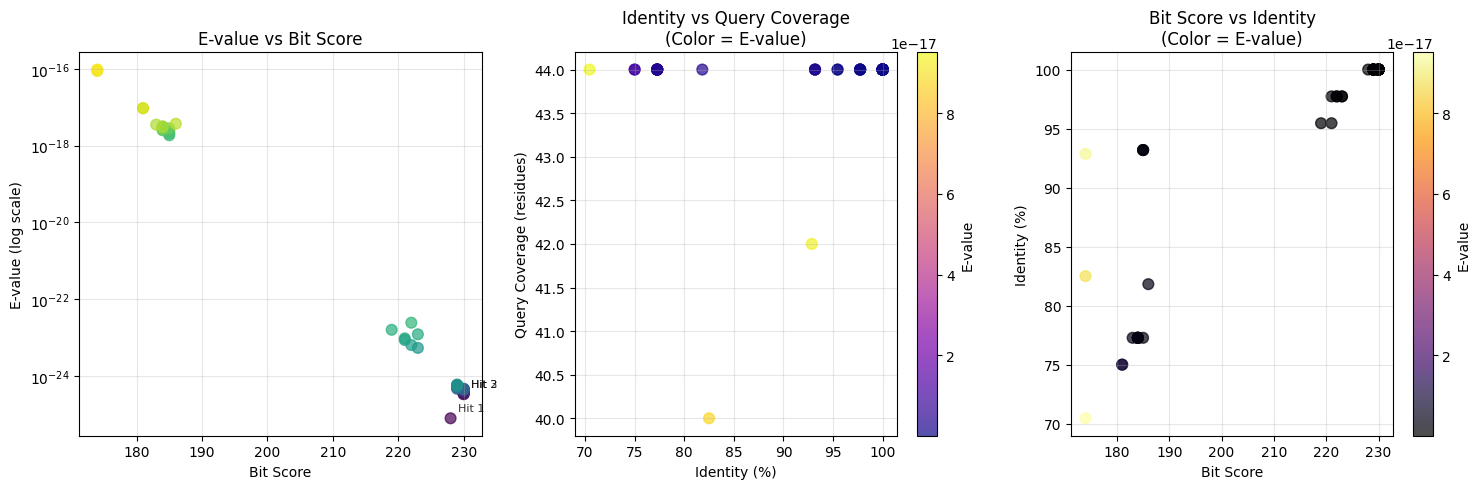


=== BLAST Results Summary ===
Number of hits: 50
Bit score range: 174.0 - 230.0
E-value range: 8.05e-26 - 9.52e-17
Identity range: 70.5% - 100.0%
Query coverage range: 40 - 44 residues

=== Top 3 Hits Details ===
Hit 1: sp|Q60529.1|
  Description: RecName: Full=GTPase HRas; AltName: Full=H-Ras-1; ...
  Bit Score: 228.0
  E-value: 8.05e-26
  Identity: 100.0%
  Coverage: 44 residues

Hit 2: sp|P79737.1|
  Description: RecName: Full=GTPase NRas; AltName: Full=Transform...
  Bit Score: 230.0
  E-value: 3.42e-25
  Identity: 100.0%
  Coverage: 44 residues

Hit 3: sp|P05774.1|
  Description: RecName: Full=Ras-like protein [Carassius auratus]
  Bit Score: 230.0
  E-value: 3.46e-25
  Identity: 100.0%
  Coverage: 44 residues

No BLAST results available for plotting
Run the BLAST cell above first to get results


In [6]:

# Protein BLAST (BLASTp) example - [NETWORK REQUIRED]
from Bio.Blast import NCBIWWW, NCBIXML
prot_query = 'MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQV'  # RAS fragment

print('Submitting BLASTp query to NCBI (this may take ~2min)...')
result_handle = NCBIWWW.qblast('blastp', 'swissprot', prot_query)
blast_record = NCBIXML.read(result_handle)

# If blast_record available, print top hits
if blast_record is not None:
    print('\nTop 5 BLASTp hits:')
    for alignment in blast_record.alignments[:5]:
        for hsp in alignment.hsps[:1]:
            print(f'{alignment.hit_id}\t{alignment.hit_def}\tE={hsp.expect}\tScore={hsp.score}')

import matplotlib.pyplot as plt
import numpy as np

hit_ids = []
descriptions = []
evalues = []
bit_scores = []
identities = []
query_coverage = []

for i, alignment in enumerate(blast_record.alignments):
    for hsp in alignment.hsps[:1]:  # Take first HSP for each alignment
        hit_ids.append(alignment.hit_id)
        descriptions.append(alignment.hit_def[:50] + "..." if len(alignment.hit_def) > 50 else alignment.hit_def)
        evalues.append(hsp.expect)
        bit_scores.append(hsp.score)
        identities.append(hsp.identities / hsp.align_length * 100 if hsp.align_length > 0 else 0)
        query_coverage.append(hsp.query_end - hsp.query_start + 1)
    
# Create comprehensive plots
plt.figure(figsize=(15, 5))

# Plot 1: E-value vs Bit Score
plt.subplot(1, 3, 1)
scatter = plt.scatter(bit_scores, evalues, alpha=0.7, s=60, c=range(len(bit_scores)), cmap='viridis')
plt.yscale('log')
plt.xlabel('Bit Score')
plt.ylabel('E-value (log scale)')
plt.title('E-value vs Bit Score')
plt.grid(True, alpha=0.3)

# Add annotations for top hits
for i, (score, evalue) in enumerate(zip(bit_scores[:3], evalues[:3])):
    plt.annotate(f'Hit {i+1}', (score, evalue), xytext=(5, 5), 
                textcoords='offset points', fontsize=8, alpha=0.8)

# Plot 2: Identity vs Query Coverage
plt.subplot(1, 3, 2)
scatter2 = plt.scatter(identities, query_coverage, alpha=0.7, s=60, c=evalues, cmap='plasma')
plt.xlabel('Identity (%)')
plt.ylabel('Query Coverage (residues)')
plt.title('Identity vs Query Coverage\n(Color = E-value)')
cbar2 = plt.colorbar(scatter2, label='E-value')
plt.grid(True, alpha=0.3)

# Plot 3: Bit Score vs Identity
plt.subplot(1, 3, 3)
scatter3 = plt.scatter(bit_scores, identities, alpha=0.7, s=60, c=evalues, cmap='inferno')
plt.xlabel('Bit Score')
plt.ylabel('Identity (%)')
plt.title('Bit Score vs Identity\n(Color = E-value)')
cbar3 = plt.colorbar(scatter3, label='E-value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f'\n=== BLAST Results Summary ===')
print(f'Number of hits: {len(bit_scores)}')
print(f'Bit score range: {min(bit_scores):.1f} - {max(bit_scores):.1f}')
print(f'E-value range: {min(evalues):.2e} - {max(evalues):.2e}')
print(f'Identity range: {min(identities):.1f}% - {max(identities):.1f}%')
print(f'Query coverage range: {min(query_coverage)} - {max(query_coverage)} residues')

# Show top 3 hits in detail
print(f'\n=== Top 3 Hits Details ===')
for i in range(min(3, len(hit_ids))):
    print(f'Hit {i+1}: {hit_ids[i]}')
    print(f'  Description: {descriptions[i]}')
    print(f'  Bit Score: {bit_scores[i]:.1f}')
    print(f'  E-value: {evalues[i]:.2e}')
    print(f'  Identity: {identities[i]:.1f}%')
    print(f'  Coverage: {query_coverage[i]} residues')
    print()
        
else:
    print('No BLAST results available for plotting')
    print('Run the BLAST cell above first to get results')


In [ ]:

# Nucleotide BLAST (BLASTn) example - [NETWORK REQUIRED]
from Bio.Blast import NCBIWWW, NCBIXML
nt_query = 'ATGCGTACGTTAGCTAGCTAGCTAGCTAG'  # synthetic

print('Submitting BLASTn query to NCBI (this may take ~4min)...')
result_handle_nt = NCBIWWW.qblast('blastn', 'nt', nt_query)
blast_record_nt = NCBIXML.read(result_handle_nt)

if blast_record_nt is not None:
    print('\nTop 5 BLASTn hits:')
    for alignment in blast_record_nt.alignments[:5]:
        for hsp in alignment.hsps[:1]:
            print(f'{alignment.hit_id}\t{alignment.hit_def}\tE={hsp.expect}\tScore={hsp.score}')


Submitting BLASTn query to NCBI (this may take ~4min)...

Top 5 BLASTn hits:
gi|1811502936|ref|XM_032533370.1|	PREDICTED: Etheostoma spectabile DnaJ (Hsp40) homolog, subfamily C, member 18 (dnajc18), mRNA	E=0.109114	Score=49.0
gi|1696103398|ref|XM_029739143.1|	PREDICTED: Salmo trutta probable glutamate--tRNA ligase, mitochondrial (LOC115178113), transcript variant X1, mRNA	E=0.109114	Score=49.0
gi|2073543437|ref|XM_012819819.3|	PREDICTED: Clupea harengus A kinase (PRKA) anchor protein 11 (akap11), transcript variant X2, mRNA	E=0.109114	Score=48.0
gi|1604821529|ref|XM_028572996.1|	PREDICTED: Perca flavescens PIH1 domain containing 2 (pih1d2), mRNA	E=0.109114	Score=48.0
gi|3039199778|ref|XM_076085841.1|	PREDICTED: Anarhichas minor DnaJ heat shock protein family (Hsp40) member B1a (dnajb1a), mRNA	E=0.109114	Score=48.0



## Exercise 4 — Sequence Embeddings (Protein & Nucleotide)
**Goal:** Provide an example of using pretrained models to compute embeddings and compare similarity without alignment.
- Protein models: ESM, ProtTrans (HuggingFace)  


In [ ]:

# Example with HuggingFace transformers (protein model) - [NETWORK REQUIRED]
# First install: pip install transformers sentencepiece torch

try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity
    
    print("Loading ESM2 model from HuggingFace...")
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
    model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
    
    # Two protein sequences to compare
    seq1 = "MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQV"
    seq2 = "MTEYKLVVVGAGGVGKSALTIKLIGRNHFVDEYDPTIEDSYRKQV"  # Same sequence for demo
    
    print(f"Sequence 1: {seq1}")
    print(f"Sequence 2: {seq2}")
    
    # Tokenize sequences
    inputs = tokenizer([seq1, seq2], return_tensors='pt', padding=True, truncation=True)
    
    # Get embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        # Use mean pooling of last hidden state
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    
    # Calculate cosine similarity
    cos_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0, 0]
    print(f'Cosine similarity between embeddings: {cos_sim:.4f}')
    
    # Show embedding dimensions
    print(f'Embedding shape: {embeddings.shape}')
    
except ImportError as e:
    print(f"Missing dependencies: {e}")
    print("Install with: pip install transformers sentencepiece torch")
    print("\nFalling back to mocked example:")
    import numpy as np
    np.random.seed(42)
    emb_a = np.random.normal(size=768)
    emb_b = np.random.normal(size=768)
    cos_sim = np.dot(emb_a, emb_b) / (np.linalg.norm(emb_a)*np.linalg.norm(emb_b))
    print('Mocked cosine similarity (offline demo):', cos_sim)
